# Contrastive CNN Variational Quantum Circuit

Quantum autoencoder on larger MNIST images by encoding the high dimensional data using DRC. Based on Quantum Autoencoder project.

In [24]:
import pennylane as qml

import warnings
warnings.filterwarnings('ignore')

### Hyperparameters

- INPUT_DATA_SIZE: The size the images will be scaled to (e.g. 12x12)  
- DRCs: The number of data reuploads in the encoder
- EPOCHS: Number of epochs to train
- LATENT_QBITS: Number qubits in the latent space
- DATA_QBITS: Number of qubits for the encoder
- KERNEL_SIZE
- STRIDE

Since the input images are 12x12, we split each image into 9 4x4 patches. We use 9 data qubits with kernel_size 4 and stride 4.
<!-- Using reduced input images size of 10x10, we split each image into 4 5x5 patches. We use 4 data qubits with kernel_size 5 and stride 5. -->

In [25]:
INPUT_DATA_SIZE = 12

DRCs = 1
EPOCHS = 10

KERNEL_SIZE = 4
STRIDE = 4

DATA_QBITS =  9
LATENT_QBITS = 5
AUX_QBITS = 1

TOTAL_QBITS = DATA_QBITS * 2 + AUX_QBITS

In [26]:
DATA_QBITS = int(((INPUT_DATA_SIZE - KERNEL_SIZE) / STRIDE + 1) ** 2 ) # Each qbit corresponds to a patch
print("DATA_QBITS: ", DATA_QBITS)

DATA_QBITS:  9


## Contrastive CNN QVC

Create pennylane device to simulate on.

In [27]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

Create CNN contrastive QVC.

In [28]:
# from models.quantum import qcnn_reupload_contrastive
# model = qcnn_reupload_contrastive.ContrastiveConvEncoderCircuit(DATA_QBITS,
#                       LATENT_QBITS,
#                       AUX_QBITS,
#                       dev1, 
#                       INPUT_DATA_SIZE, 
#                       kernel_size=4, 
#                       stride=4, 
#                       DRCs=DRCs)


Plot the circuit:

In [29]:
# model.plot_circuit()

Draw the circuit:

In [30]:
# model.draw_circuit()

We confirm that the parameter of the two circuits are the same with similar parameter.

tensor(0.5376, dtype=torch.float64)
 0: ──RZ(0.91)──RY(0.85)──RZ(0.46)──RZ(0.88)──RY(0.98)──RZ(0.77)──RZ(0.47)──RY(1.30)──RZ(0.54)
 1: ──RZ(0.67)──RY(1.09)──RZ(1.32)──RZ(0.93)──RY(0.90)──RZ(0.42)──RZ(0.90)──RY(0.76)──RZ(0.41)
 2: ──RZ(0.68)──RY(0.79)──RZ(1.03)──RZ(1.35)──RY(0.55)──RZ(0.33)──RZ(0.95)──RY(1.21)──RZ(1.27)
 3: ──RZ(0.92)──RY(0.28)──RZ(0.71)──RZ(0.38)──RY(0.61)──RZ(1.72)──RZ(1.66)──RY(0.51)──RZ(0.39)
 4: ──RZ(0.67)──RY(0.31)──RZ(0.76)──RZ(1.04)──RY(0.70)──RZ(0.15)──RZ(0.92)──RY(0.65)──RZ(0.66)
 5: ──RZ(1.35)──RY(0.53)──RZ(0.20)──RZ(0.88)──RY(0.06)──RZ(0.34)──RZ(0.58)──RY(1.20)──RZ(0.57)
 6: ──RZ(1.02)──RY(0.89)──RZ(0.22)──RZ(1.06)──RY(1.33)──RZ(0.21)──RZ(1.22)──RY(0.40)──RZ(0.62)
 7: ──RZ(1.42)──RY(1.02)──RZ(0.61)──RZ(1.08)──RY(0.10)──RZ(0.67)──RZ(1.43)──RY(0.42)──RZ(0.28)
 8: ──RZ(0.78)──RY(1.53)──RZ(0.73)──RZ(0.68)──RY(0.65)──RZ(0.22)──RZ(0.61)──RY(0.89)──RZ(0.65)
 9: ──RZ(0.91)──RY(0.85)──RZ(0.46)──RZ(0.88)──RY(0.98)──RZ(0.77)──RZ(0.47)──RY(1.30)──RZ(0.54)
10: ──RZ(0.67)

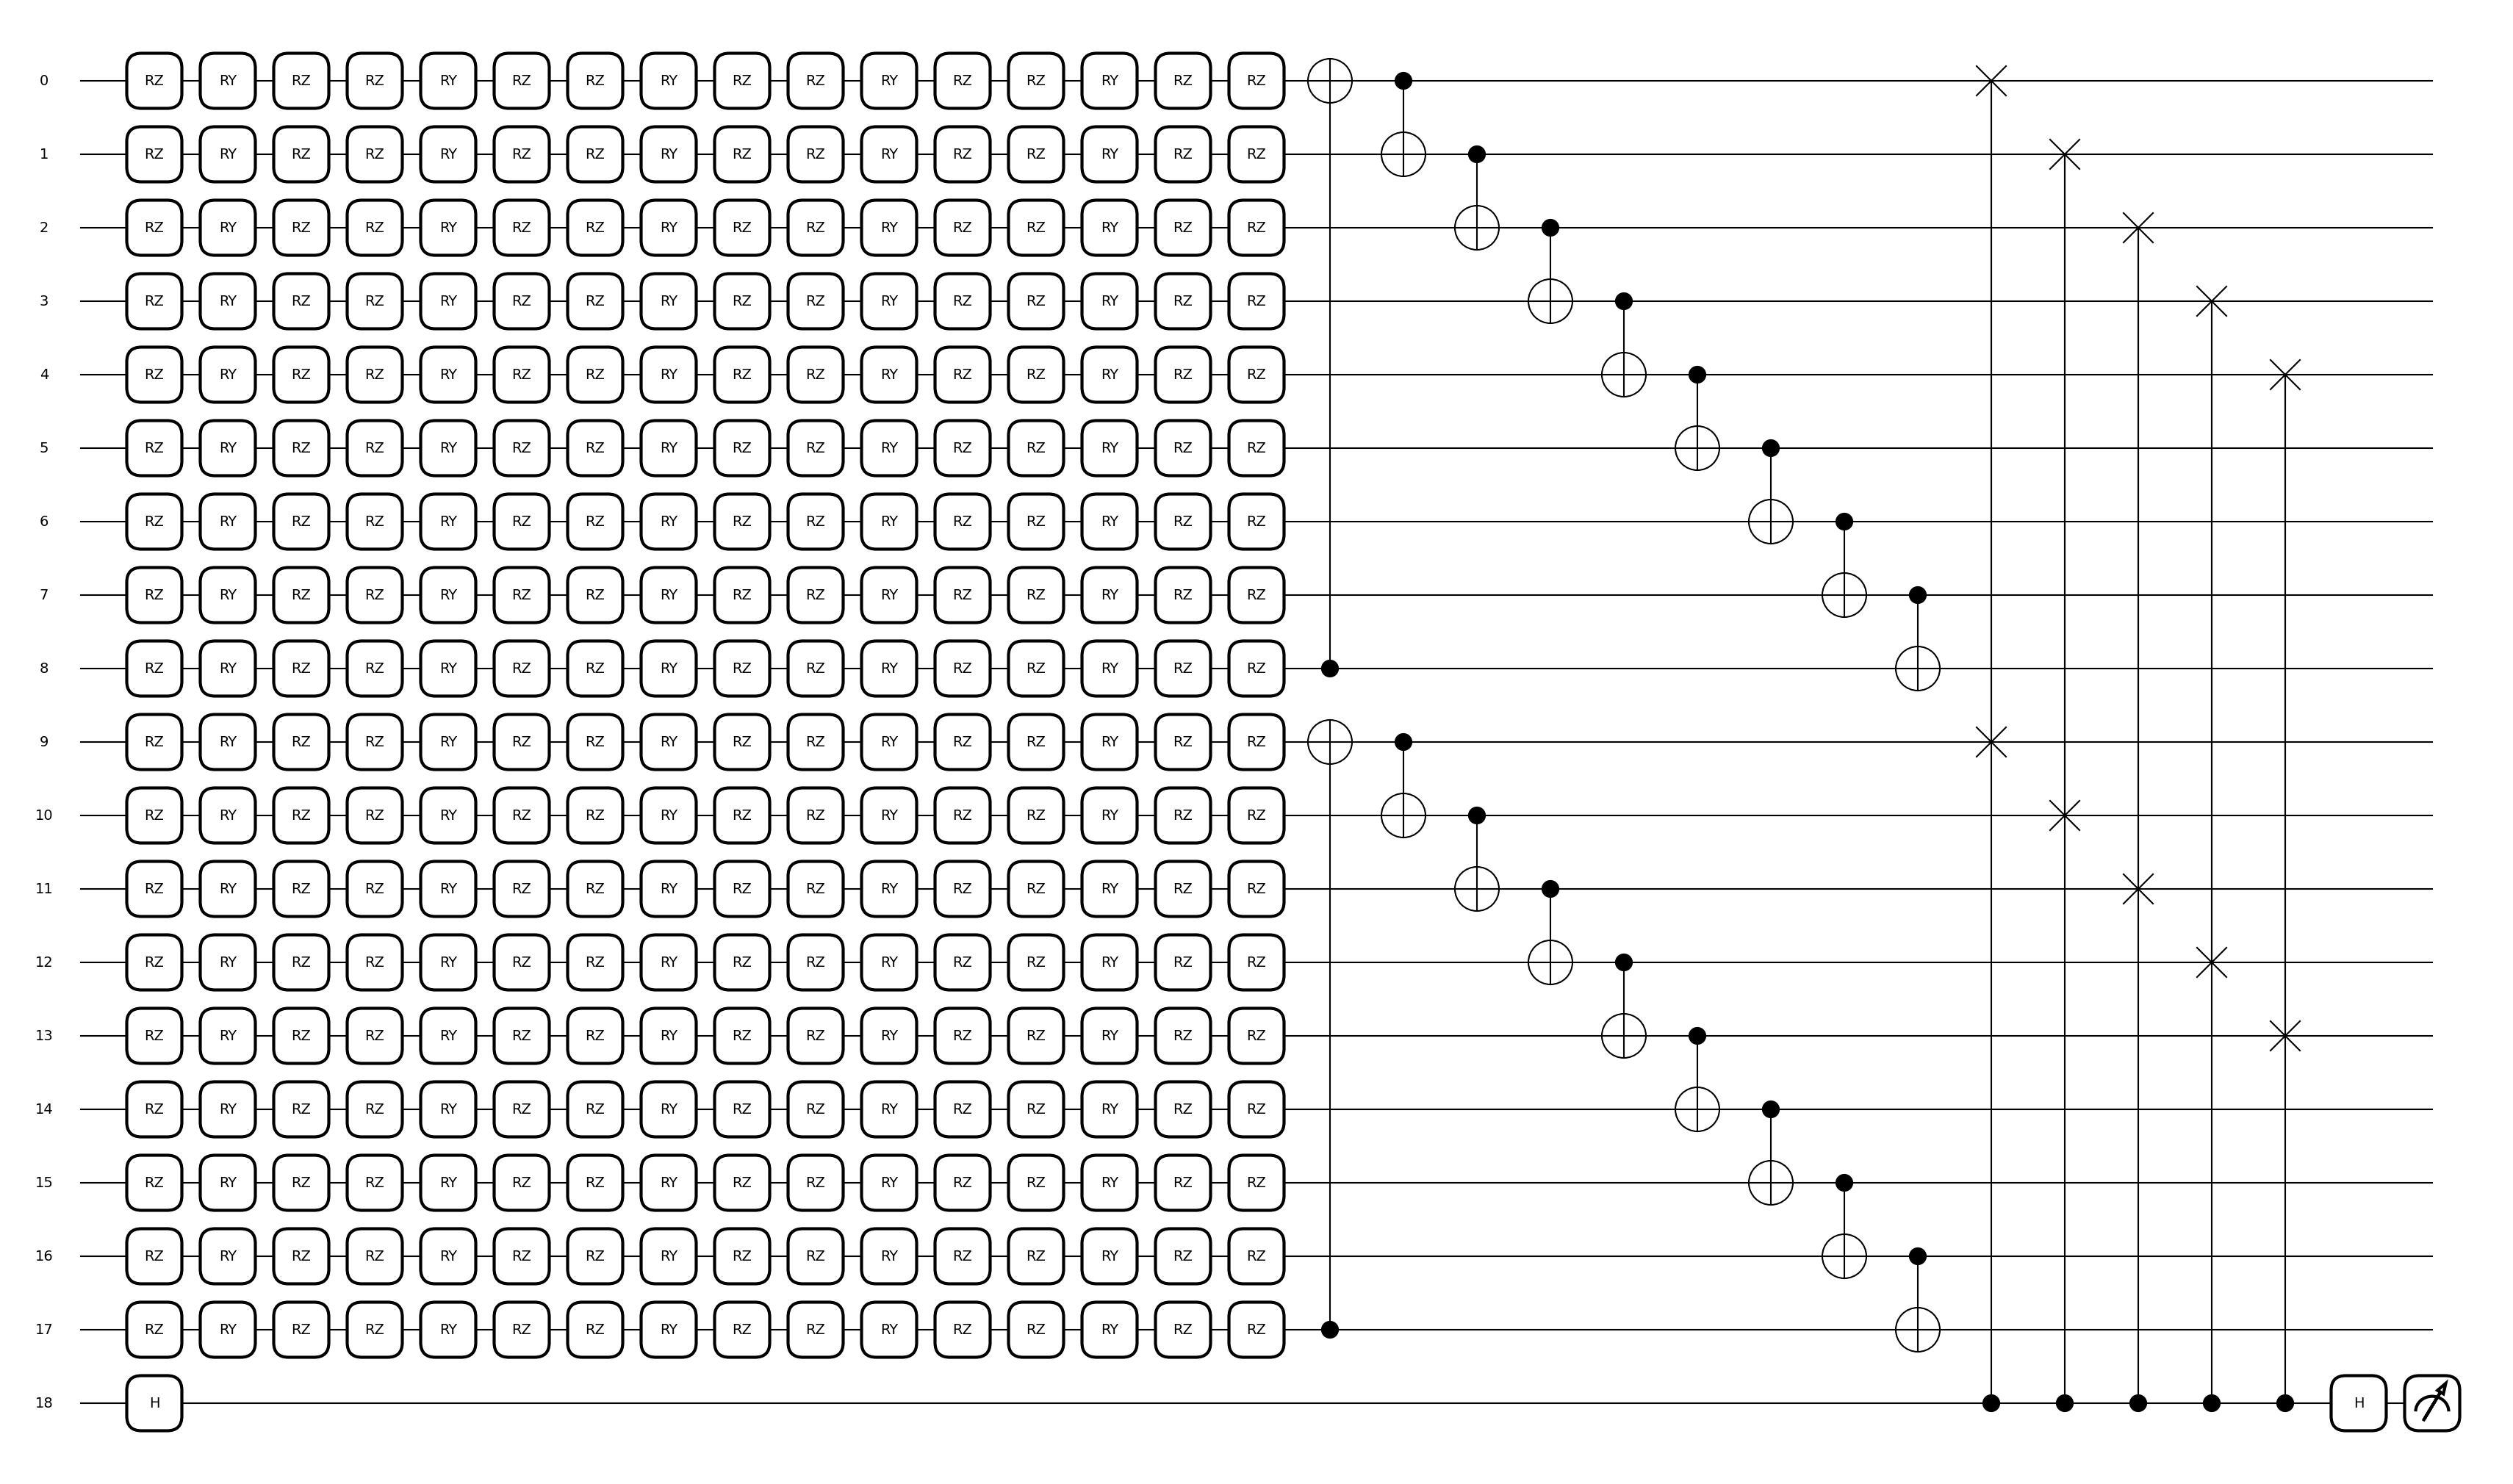

In [31]:
import torch

from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer
from qml_ssl.data import load_mnist_img
from qml_ssl.models.quantum import qcnn_reupload_contrastive

import matplotlib.pyplot as plt


classes = (3, 6)
reduced_dim = INPUT_DATA_SIZE
dataset_size = (256, 64)

mnist_data = load_mnist_img(classes=classes, reduced_dim=reduced_dim, dataset_size=dataset_size, data_dir="../data/")

def create_data_loader(data, labels, batch_size=16, shuffle=True, num_workers=4):
    dataset = TensorDataset(data, labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return data_loader

train_loader = create_data_loader(mnist_data["train_data"], mnist_data["train_labels"])
val_loader = create_data_loader(mnist_data["test_data"], mnist_data["test_labels"])

model = qcnn_reupload_contrastive.QuantumContrastive(
                DATA_QBITS, 
                LATENT_QBITS,
                AUX_QBITS,
                dev1, 
                INPUT_DATA_SIZE, 
                KERNEL_SIZE, 
                STRIDE, 
                DRCs)

# model = torch.compile(model)

model.quantum_circuit.plot_circuit()
model.quantum_circuit.draw_circuit()

In [32]:

# Training the model
logger = CSVLogger(save_dir="logs/", name="MNISTQuantum", version=0)
trainer = Trainer(max_epochs=10, logger=logger, devices=0)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | quantum_layer | Sequential | 288   
---------------------------------------------
288       Trainable params
0         Non-trainable params
288       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0:  70%|███████   | 14/20 [1:00:40<26:00, 260.00s/it, loss=0.49, v_num=0] 

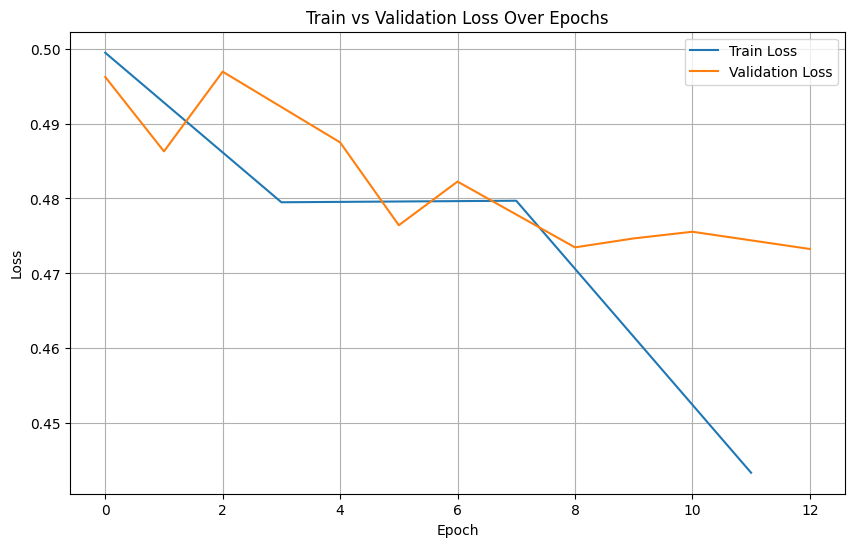

In [ ]:
import pandas as pd
# Plot training and validation loss
metrics_df = pd.read_csv(f"{logger.log_dir}/metrics.csv")
train_loss_epoch = metrics_df['train_loss'].dropna()
val_loss_epoch = metrics_df['val_loss'].dropna()
max_length = max(len(train_loss_epoch), len(val_loss_epoch))
train_loss_epoch = train_loss_epoch[:max_length]
val_loss_epoch = val_loss_epoch[:max_length]

plt.figure(figsize=(10, 6))
plt.plot(train_loss_epoch, label='Train Loss')
plt.plot(val_loss_epoch, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
metrics_df

,val_loss,epoch,step,train_loss
0,0.496212,0,15,NaN
1,0.486285,1,31,NaN
2,0.496918,2,47,NaN
3,NaN,3,49,0.479494
4,0.487484,3,63,NaN
5,0.476429,4,79,NaN
6,0.482254,5,95,NaN
7,NaN,6,99,0.479698
8,0.473474,6,111,NaN
9,0.474671,7,127,NaN
